# Chord Cleaning

### Imports

In [1]:
import pandas as pd
import numpy as np
import random
import string
import re
import json
import ast
from collections import Counter
import statistics as stats
import matplotlib.pyplot as plt
import os

data_path = os.getenv('DATA_PATH')

### Getting workable DF

In [2]:
raw_df = pd.read_csv(data_path)
slim_raw_df = raw_df[['artist_name', 'song_name', 'chords', 'genres', 'popularity']]
slim_raw_df.head(3)

,artist_name,song_name,chords,genres,popularity
0,Justin Bieber,"10,000 Hours",{3: 'G G/B ...,"['canadian pop', 'pop', 'post-teen pop']",100
1,Justin Bieber,2 Much,"{1: 'Intro: F#m7 D2 ', 4: 'F#m7 ', 8: 'D2 ', ...","['canadian pop', 'pop', 'post-teen pop']",100
2,Justin Bieber,2u (feat. David Guetta),{1: 'Em D C C...,"['canadian pop', 'pop', 'post-teen pop']",100


In [3]:
first_raw = ast.literal_eval(slim_raw_df.loc[0, 'chords'])
first_raw

{3: 'G             G/B                         C ',
 5: '                  G ',
 7: 'G                  G/B                         C ',
 9: '                G ',
 13: '         G         Em             C       G     ',
 15: '     G        Em                C   G ',
 19: '          G            Em        C            G    ',
 21: '      G              Em                  C              G    ',
 23: '      G           Em             C         G    ',
 25: '        G            Em           C          G    ',
 27: '           G        Em       C        G            ',
 31: 'G             G/B                       C ',
 33: '                 G ',
 35: 'G                G/B                C        ',
 37: '                G ',
 41: '         G         Em             C       G     ',
 43: '     G        Em                C   G ',
 47: '          G            Em        C            G    ',
 49: '      G              Em                  C              G    ',
 51: '      G           Em       

## Data Exploration

the song is 35 measures long.
the first 4 lines of chords are:
G-------------G/B-------------------------C-
(length: 44)
------------------G-
(length: 20)
G------------------G/B-------------------------C-
(length: 49)
----------------G-
(length: 18)


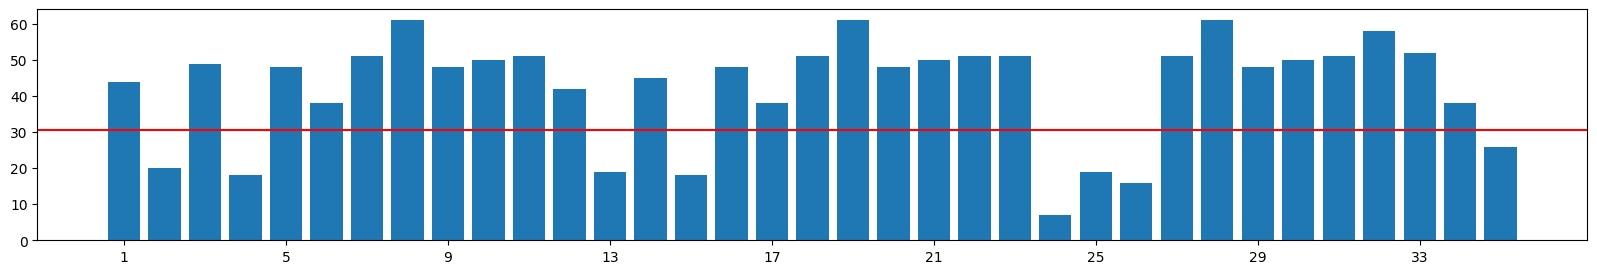

In [4]:
song_ch_lol = []
i = 0

song1 = slim_raw_df.chords[0]

song_mm_ch_dict = ast.literal_eval(song1)
song_ch_lol = [ch for ch in song_mm_ch_dict.values()]
max_line = len(song_ch_lol)

print(f'the song is {max_line} measures long.')
print('the first 4 lines of chords are:')
for ch in song_ch_lol:
    new = ch.replace(" ", "-")
    print(new)
    l = len(new)
    print(f'(length: {l})')
    i += 1
    if i == 4: break

# get line lengths
line_lens = [len(x) for x in song_ch_lol]
max_line_len = max(line_lens)

# {measure_no: chords_list}: dict
measures = [x for x in range(1, len(song_ch_lol)+1)]

fig1, ax1 = plt.subplots(figsize=(20,3))
ax1.axhline(max_line_len/2, color='red')
ax1.bar(measures, line_lens)
xt = np.arange(1, max_line+1, 4)
ax1.set(xticks=xt, xticklabels=xt)
plt.show()

#### See Chord Frequency

In [5]:
chords_ser_raw = slim_raw_df.chords.copy()

chords_ser_lists = pd.Series(index=range(len(slim_raw_df)), dtype='object')

for i, song in enumerate(chords_ser_raw):
    song_mm_ch_dict = ast.literal_eval(song)
    song_ch_lol = [ch for ch in song_mm_ch_dict.values()]
    chords_ser_lists.iloc[i] = song_ch_lol

chords_ser_lists.head()

0    [G             G/B                         C ,...
1    [Intro: F#m7  D2 , F#m7 , D2 , F#m7 ,         ...
2    [Em            D         C               C  D ...
3    [ Intro: Em  Bm  Am  C   (2x) ,           Em  ...
4    [Intro: Gm - Dm - C - C   x2 ,        Gm      ...
dtype: object

In [6]:
chords_counter = Counter()
for song in chords_ser_lists:
    for line in song:
        l = line.split(' ')
        chords_counter.update(l)
del chords_counter['']

chord_count_df = pd.Series(dict(chords_counter)).to_frame('chord_count')
sorted_cc_df = chord_count_df.sort_values(by='chord_count', ascending=False)
print('the total amount of unique "chords" is: ', len(sorted_cc_df))

the total amount of unique "chords" is:  103294


In [7]:
# pd.options.display.max_rows = 100
# sorted_cc_df.head(100)

In [8]:
letters = list(string.ascii_uppercase)[:7]
non_chord_filter = [chord for chord in sorted_cc_df.index if chord[0] in letters]
filtered_cc_df = sorted_cc_df[sorted_cc_df.index.isin(non_chord_filter)]
print('the total amount of unique "chords" is: ', len(filtered_cc_df))

the total amount of unique "chords" is:  77872


In [9]:
# pd.set_option('display.max_rows', 200)
# filtered_cc_df.iloc[0:200]

In [10]:
# slim_chord_counts_dict = {}
# for chord, count in chords_count_dict.items():
#     if count <= low_freq_to_remove:
#         pass
#     else:
#         slim_chord_counts_dict[chord] = count

## Cleaning

### Test

In [11]:
# editing repeats
test_chords = 'Intro: Gm - Dm - C - C   x2 Gm7   F % Csus4/D'
chords_wo_reps = ''

# find repeat symbols (%, - , x2, 2x) and replace with preceding chord
if re.findall(r'%|2x|x2|\s-\s', test_chords):
    reps = re.findall(r'(\S+)(?=\s*(%|2x|x2|\s-\s))|([A-Z]\S+)', test_chords)
    for x in reps:
        if x[0] != '':
            chords_wo_reps += x[0] + ' ' + x[0] + ' '
        else:
            chords_wo_reps += x[2] + ' '
else:
    chords_wo_reps = test_chords
print(test_chords)
print(chords_wo_reps)

Intro: Gm - Dm - C - C   x2 Gm7   F % Csus4/D
Intro: Gm Gm Dm Dm C C C C Gm7 F F Csus4/D 


In [12]:
# cleaning up chords
test2_chords = '      Intro: G-F-G  FMm7,    G\\F\\F\\F,       Amsus6 GM7/D#   (F3)    BbFbCG     '

# remove non-useful punctuation
no_punc_ch = re.sub(r'-+|[()|,.]|\\', ' ', test2_chords)

# remove spaces
mult_sp_rem_ch = re.sub(r'\s+', ' ', no_punc_ch)
beg_sp_rem_ch = re.sub(r'^\s+', '', mult_sp_rem_ch)
end_sp_rem_ch = re.sub(r'\s+$', '', beg_sp_rem_ch)
    
end_sp_rem_ch

'Intro: G F G FMm7 G F F F Amsus6 GM7/D# F3 BbFbCG'

### Clean DF

In [122]:
raw_chords_ser = chords_ser_lists.copy()
cleaned_chords_ser = pd.Series(index=range(len(raw_chords_ser)), dtype='object')

In [123]:
# r'(?<!\s)/(?=[0-9])'

In [124]:
# bar charts
re1 = r'\S*[|]\S+[|]'
# repeat symbols 
re2 = r'%|2x|x[0-9]|x\s+[0-9]|\s-\s|\s/\s'
# non-useful punctuation
re3 = r'[|,.*?]|\\|~'
# more than 3 numbers in a row
re4 = r'[0-9]{3,}'
# words starting with letters after G
re5 = r'\s+[H-Zh-z]\w*' 
# special words
words = ['INTRO', 'INTERLUDE', 'BRIDGE', 'INTRODUÇÃO', 'INSTRUMENTAL', 
         'SOLO', 'CHORUS', 'RIFF', 'BREAK', 'GUITAR', 'VERSE', 'dução', 
         'final', 'once', '-once', 'hammer', 'outro', '-stop']
re6 = r"|".join(words)

full_re = re.compile("|".join([re1, re2, re3, re4, re5, re6]), re.IGNORECASE)
full_re

re.compile(r'\S*[|]\S+[|]|%|2x|x[0-9]|x\s+[0-9]|\s-\s|\s/\s|[|,.*?]|\\|~|[0-9]{3,}|\s+[H-Zh-z]\w*|INTRO|INTERLUDE|BRIDGE|INTRODUÇÃO|INSTRUMENTAL|SOLO|CHORUS|RIFF|BREAK|GUITAR|VERSE|dução|final|once|-once|hammer|outro|-stop',
           re.IGNORECASE|re.UNICODE)

In [125]:
for i, song in enumerate(raw_chords_ser):
    
    cleaned_song = ''
    j = 0
    for line in song:

        # remove unhelpful symbols (as shown above)
        subs = re.sub(full_re, ' ', line, )
        
        # remove parentheses, brackets, and colons
        cleaned_string = re.sub(r'[(){}:]', '', subs)

        # remove multiple spaces
        mult_sp_rem_ch = re.sub(r'\s+', ' ', cleaned_string)
        
        # remove front and trailing white spaces
        beg_end_sp_rem_song = re.sub(r'^\s+|\s+$', '', mult_sp_rem_ch)

        if j < len(song)-1:
            cleaned_song += beg_end_sp_rem_song + ' '
            j += 1
        else:
            cleaned_song += beg_end_sp_rem_song
            
    cleaned_chords_ser.iloc[i] = cleaned_song
    
cleaned_chords_ser.head()

0    G G/B C G G G/B C G G Em C G G Em C G G Em C G...
1    F#m7 D2 F#m7 D2 F#m7 D2 E F#m7 A/C# E D2 E F#m...
2    Em D C C D Em Em D C C D Em Em D C Am D Em G C...
3    Em Bm Am C Em Bm Am C Em Bm Am C Bm Em Bm Am C...
4    Gm Dm C C Gm Dm C C Gm Dm C C Gm A# C Gm A# C ...
dtype: object

In [120]:
cleaned_chords_counter = Counter()
for song in cleaned_chords_ser:
    try:
        l = song.split(' ')
    except:
        print(song)
        break
    cleaned_chords_counter.update(l)
del cleaned_chords_counter['']

cleaned_chord_count_df = pd.Series(dict(cleaned_chords_counter)).to_frame('chord_count')
cleaned_cc_df = cleaned_chord_count_df.sort_values(by='chord_count', ascending=False).reset_index(names=['chord'])
print('the total amount of unique "chords" is: ', len(cleaned_cc_df))
# cleaned_cc_df.head(100)

the total amount of unique "chords" is:  462


In [121]:
pd.set_option('display.max_rows', 500)
cleaned_cc_df[:100]

,chord,chord_count
0,G,10139
1,C,8139
2,D,6596
3,Em,5959
4,Am,5485
5,F,4998
6,A,4532
7,E,3036
8,Bm,2711
9,Dm,2143


In [80]:
for idx, c in enumerate(cleaned_chords_ser):
    if ' x ' in c:
        print(idx, c)

101 Am F G D Am F G D Am F G D Am F G D F Am G F Am G F Am G F Am G vocalização Am F G D Am F G D Am F G D Am F G D F Am G F Am G F Am G F Am G F Am G F Am G F Am G F Am G vocalização x Am F G D
129 x Am Em F G Am Em F G x Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G F G G Am Em F G Am Am F G Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G Am Em F G Am Am F G Am Em F G Am Em F G
284 D A Em G x D A Em G D A Em G D A Em G D A Em G D A Em G D A Em G A Hold D A Em G D A Em G D A Em G D A Em G D A Em G D A Em G D A Em G A D A Em G D A Em G D A Em G Em D D A Em G D A Em G hold D A Em G D A Em G A D A Em G D A Em G A Hold D A Em G D A Em G Ending D A Em G D
353 D A Em G x D A Em G D A Em G D A Em G D A Em G Em G D A Em G D A Em G D A Em G D A Em G D A Em G D D A Em G D A Em G D A Em G D A Em G D A Em G D A Em G D A Em G D A Em G D Em G D A Em G D A Em G D A Em G D A Em G D A Em

In [81]:
for m in raw_chords_ser[101]:
    print(m)

(intro) Am   F   G   D  
      Am                                      F  
  G                                   D  
  Am                                F  
  G                                 D  
            Am  
          F  
      G  
 D  
F        Am           G  
F        Am           G  
F          Am           G  
                          F  
       Am  
        G  
(vocalização) Am   F   G   D  
  Am                              F  
  G                                    D  
    Am                                 F  
        G                              D  
            Am  
           F  
      G  
      D  
F        Am           G  
F        Am           G  
F          Am           G  
                          F  
       Am  
        G  
F        Am           G  
F        Am           G  
F          Am           G  
                          F  
       Am  
        G  
(vocalização 2x) Am   F   G   D  


In [ ]:
letters = list(string.ascii_uppercase)[:7]
non_chord_filter = [chord for chord in sorted_cc_df.index if chord[0] in letters]
cc_df = sorted_cc_df[sorted_cc_df.index.isin(non_chord_filter)]
cc_df.iloc[100:200]

## Creating List of Correctly Formatted Chords

In [ ]:
major_chords = ['C', 'C#', 'Db', 'D', 'D#', 'Eb', 'E', 'F', 'F#', 'Gb', 'G', 'G#', 'Ab', 'A', 'A#', 'Bb', 'B']

In [ ]:
chords_df = pd.DataFrame(index=['', 'm', 'dim', 'aug', '5', 'aug5', '5b7',
                                'dim7', 'hdim7', 'm7', 'm-M7', '7', 'aug7', 'M7',  
                                'm9', '9', '7b9',  'M9', 'm11', '11',
                                'add2', 'add4', 'add6', 'add9', 
                                'madd2', 'madd4', 'madd6', 'madd9', 
                                '7add4', '7addb6', '7add6', 
                                'msus2', 'msus4', '7sus2', '7sus4', 'sus2', 'sus4'
                                ],
                         columns=major_chords)


In [ ]:
for idx in chords_df.index:
    new_chords = [m + idx for m in major_chords]
    chords_df.loc[idx, :] = new_chords
chords_df.rename(index={'': 'major'}, inplace=True)
chords_df.head(3)

In [ ]:
sharp_notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 
                'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
flats_notes = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B', 
                'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
sharp_keys = ['D', 'E', 'G', 'A', 'B', 'Dm', 'Em', 'Fm', 'Bm']
flats_keys = ['C', 'F', 'Cm', 'Gm', 'Am']

slash_indexes = ['dim/b7', 'm/2', 'm/b3', 'm/3', 'm/4', 'm/5', 'm/6','m/b7', 'm/7',
                'm7/b3', 'm7/4', 'm7/b5', 'm7/5', 'm7/7', 
                '/2', '/b3', '/3', '/4', '/5', '/6','/b7', '/7', 
                '7/b2', '7/2', '7/b3', '7/3', '7/4', '7/5', '7/b6', '7/6','7/7', 
                '9/b3', '9/3', '9/4', '9/5', '9/6', '9/7',
                'M7/2', 'M7/b3', 'M7/3', 'M7/4', 'M7/5', 'M7/6','M7/b7']

whole_to_half = {'b2': 1, '2': 2, 'b3': 3, '3': 4, '4': 5, 'b5': 6,
                 '5': 7, 'b6': 8,'6': 9, 'b7': 10, '7': 11}

In [ ]:
# big function
def get_slash_notes(slash_indexes, columns):
    slash_chord = pd.DataFrame(index=slash_indexes, columns=columns)
    i = 0 
    
    def find_slash(chord, notes, i):
        for si in slash_indexes:
            s = si.split('/')
            h = whole_to_half[s[1]]
            sc = f'{chord}{s[0]}/{notes[i+h]}'
            slash_chord.loc[si, chord] = sc
    
    def sort_f_s(chord, notes):
        for n in notes:
            if len(chord) > 1:
                i = notes.index(chord)
                find_slash(chord, notes, i)
            else:
                i = notes.index(chord[0])
                find_slash(chord, notes, i)
    
    for chord in columns:
        if chord in sharp_keys or '#' in chord:
            sort_f_s(chord, sharp_notes)
        else:
            sort_f_s(chord, flats_notes)
                
            
    return slash_chord

In [ ]:
slash_chords_df = pd.concat([chords_df, get_slash_notes(slash_indexes, chords_df.columns)])
slash_chords_df

## Shove chords into correct format

In [ ]:
substitutions = {'maj': '', ',': '', 'º': 'dim', '*': 'dim', '5+': 'aug', '7M': 'M7',
                 'maj7': 'M7', 'm7b5': 'hdim7', 'm7+': 'm-M7', '7+': 'aug7', 
                 '79': '9', 'm5-/7': 'dim/b7', '711': '7add4', '7b13': '7addb6', 
                 '713': '7add6', '4/7/9': '9add4', '69': '9add6', '/9-': '/b2', 
                 '/9': '/2', '/5-': '/b5', '/13-': '/b6', '/5+': '/b6', '/13': '/6',
                 '2': 'add2', '4': 'add4', '6': 'add6', 'sus': 'sus4'
                 }

In [ ]:
def merge_chords(chords_column):
    chords_column_copy = chords_column.copy()
    merged_chords = []
    rejected = []
    added = []
    
    # compare against df
    def counters(chord):
        if chord in slash_chords_df.columns:
            added.append(chord)
        elif chord in slash_chords_df.values:
            print(chord, 'in_df')
            added.append(chord)
        else:
            print(chord, 'womp')
            rejected.append(f'{chord}-f')
        return 
    
    # if keys in subs in chord, replace with values
    def check_subs(chord):
        for k, s in substitutions.items():
            if k in chord: 
                print(k, chord)
                ch_sub = chord.replace(k, s)
                print(ch_sub, 'subbed')
                return ch_sub
            else:
                return chord
    
    for song in chords_column_copy:
        merged_song = {}
        for m, chords in song.items():
            measure = chords.split()
            for idx, ch in enumerate(measure):
                            
                            # START HERE

                if idx == 0 and m == ?:
                    chs = check_subs(ch)
                    counters(chs)
                    measure[idx] = chs
                else:
                    chs = check_subs(ch)
                    counters(chs)
                    measure[idx] = chs                
            merged_song[m] = measure
        merged_chords.append(merged_song)
    
    added_c = Counter(added)
    rejects_c = Counter(rejected)
    
    added_df = pd.Series(dict(added_c)).to_frame('added').sort_values(by='added', ascending=False)
    rejects_df = pd.Series(dict(rejects_c)).to_frame('rejects').sort_values(by='rejects', ascending=False)
 
    return pd.DataFrame(merged_chords).T, added_df, rejects_df

In [ ]:
# merged, rejects, adds = merge_chords(split_raw_df.chords[0])
split_raw_df.chords[0]

#### For next time:
- fix rejects (reject) tag

In [ ]:
rejects_counter = Counter()
for r in rejects:
    for value in song.values():
        l = value.split(' ')
        chords_counter.update(l)

rejects_df = pd.Series(dict(rejects_counter)).to_frame('rejects')
sorted_rej_df = rejects_df.sort_values(by='rejects', ascending=False)
sorted_rej_df

In [ ]:
# # big function
# def translate_slashes(slash_indexes, columns):
#     slash_chord = pd.DataFrame(index=slash_indexes, columns=columns)
#     i = 0 
    
#     def find_slash(chord, notes, i):
#         for si in slash_indexes:
#             s = si.split('/')
#             h = whole_to_half[s[1]]
#             sc = f'{chord}{s[0]}/{notes[i+h]}'
#             slash_chord.loc[si, chord] = sc
    
#     def sort_f_s(chord, notes):
#         for n in notes:
#             if n in chord :
#                 i = notes.index(chord[0])
#                 find_slash(chord, notes, i)
#             elif len(chord) > 1:
#                 if '#' == chord[1]:
#                     i = sharp_notes.index(chord[:2])
#                     find_slash(chord, sharp_notes, i)
#                 elif 'b' == chord[1]:
#                     i = flats_notes.index(chord[:2])
#                     find_slash(chord, flats_notes, i)
    
#     for chord in columns:
#         sort_f_s(chord, sharp_notes)
#         sort_f_s(chord, flats_notes)
                
            
#     return slash_chord

In [ ]:
# slash_chords_df = pd.concat([chords_df, get_slash_notes(slash_indexes, chords_df.columns)])
